<a href="https://colab.research.google.com/github/merazAfridi/Blood-Cell-Segmentation/blob/main/3_Blood_Cell_Segmentation_R2U_net_(128).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
from skimage.transform import resize
from skimage.io import imread, imshow
from tensorflow import keras


In [ ]:
import tensorflow as tf
import google.protobuf

print("TensorFlow version:", tf.__version__)
print("Protobuf version:", google.protobuf.__version__)


TensorFlow version: 1.15.0
Protobuf version: 3.19.0


In [ ]:
data_path = r'C:\Users\User\Final data'

In [ ]:
image_data_path =r'C:\Users\User\Final data\Final data\New folder\Original'
mask_data_path =r'C:\Users\User\Final data\Final data\New folder\Mask'

(1328, 128, 128, 3)
uint8


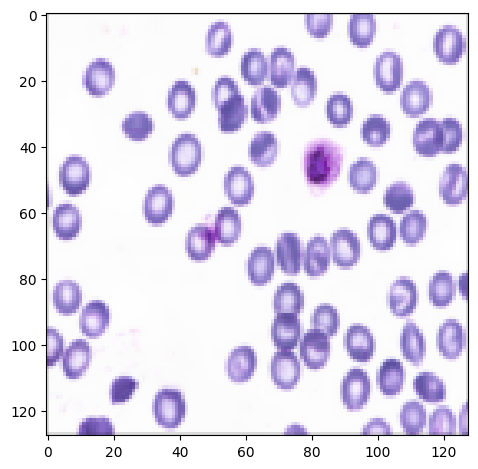

In [ ]:
#X train pure images from dataset
row = 128
columns = 128

train_data_path =r'C:\Users\User\Final data\Final data\New folder\Original'
training_images = os.listdir(train_data_path)
training_images.sort()


X = np.zeros((len(training_images), row, columns, 3), dtype=np.uint8)

index = 0
for x in training_images:
    path = os.path.join(image_data_path, x)
    image = imread(path)
    image = resize(image, (row, columns), mode='constant', preserve_range=True)

    X[index] = image
    index += 1

print(X.shape)

print(X.dtype)
imshow(X[0])

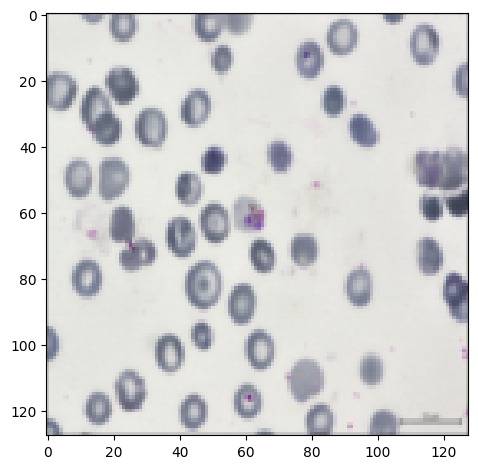

In [ ]:
imshow(X[10])

(1328, 128, 128, 3)
uint8


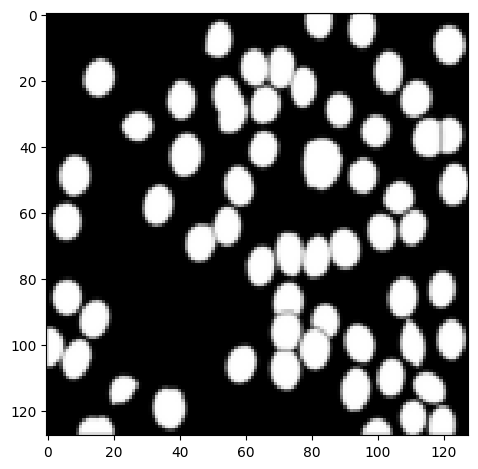

In [ ]:
## y train pure masks from dataset

train_data_path =r'C:\Users\User\Final data\Final data\New folder\Mask'
training_masks = os.listdir(train_data_path)
training_masks.sort()

y = np.zeros((len(training_masks), row, columns, 3), dtype=np.uint8)

index = 0
for x in training_masks:
    path = os.path.join(mask_data_path, x)
#     print(path)
    image = imread(path)
    image = resize(image, (row, columns), mode='constant', preserve_range=True)
    #image.resize((128,128,1))
    y[index] = image
    index += 1

print(y.shape)
type(y)
print(y.dtype)
imshow(y[0])

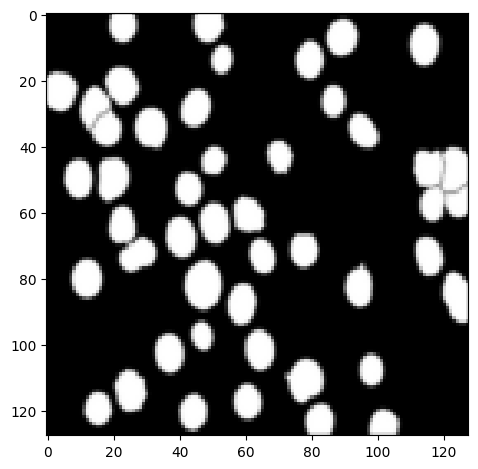

In [ ]:
imshow(y[10])

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)
print()
print(X_test.shape)
print(y_test.shape)



(1062, 128, 128, 3)
(1062, 128, 128, 3)

(266, 128, 128, 3)
(266, 128, 128, 3)


In [ ]:
y_train = y_train.astype('bool')
print(y_train.dtype)

bool


In [ ]:
def dice_coef(a, b):

    hi = a
  #  hi = tf.dtypes.cast(hi, tf.float32)
    pred = b
    hi = K.flatten(hi)
    pred = K.flatten(pred)
    upper_part = 2 * K.sum((hi * pred))
    lower_part = K.sum(hi + pred)
    dice = upper_part / lower_part
    return dice

def dice_coef_loss(a, b):
    loss = 1 - dice_coef(a, b)
    return loss

def jaccard_index(a, b):
    hi = a
    pred = b
    hi = K.flatten(hi)
    pred = K.flatten(pred)
    numerator = K.sum(hi * pred)
    denominator = K.sum((hi + pred) - (hi * pred))
    iou = numerator / denominator
    return iou

In [ ]:
#Libraries
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dropout, Lambda, Conv2D, Conv2DTranspose
# from keras.backend as K
import tensorflow.keras.backend as K
import tensorflow as tf


In [ ]:
# Import necessary libraries from TensorFlow's Keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Reshape, Permute, Activation, Input, add, multiply
from tensorflow.keras.layers import concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Lambda
import tensorflow.keras.backend as K


In [ ]:
#r2u net

In [ ]:
# UpSampling and Concatenation for U-Net
def up_and_concate(down_layer, layer, data_format='channels_last'):
    if data_format == 'channels_last':
        in_channel = down_layer.get_shape().as_list()[3]  # NHWC format
    else:
        in_channel = down_layer.get_shape().as_list()[1]  # NCHW format

    # Upsample the down_layer
    up = UpSampling2D(size=(2, 2), data_format=data_format)(down_layer)

    # Concatenate the upsampled and skip connections
    if data_format == 'channels_last':
        my_concat = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=3))
    else:
        my_concat = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=1))

    concate = my_concat([up, layer])

    return concate

# Recurrent Residual Block for R2U-Net
def rec_res_block(input_layer, out_n_filters, batch_normalization=False, kernel_size=[3, 3], stride=[1, 1], padding='same', data_format='channels_last'):
    if data_format == 'channels_last':
        input_n_filters = input_layer.get_shape().as_list()[3]  # NHWC format
    else:
        input_n_filters = input_layer.get_shape().as_list()[1]  # NCHW format

    # Skip connection if input and output channels differ
    if out_n_filters != input_n_filters:
        skip_layer = Conv2D(out_n_filters, [1, 1], strides=stride, padding=padding, data_format=data_format)(input_layer)
    else:
        skip_layer = input_layer

    layer = skip_layer
    for j in range(2):  # Recurrent loop
        for i in range(2):
            if i == 0:
                layer1 = Conv2D(out_n_filters, kernel_size, strides=stride, padding=padding, data_format=data_format)(layer)
                if batch_normalization:
                    layer1 = BatchNormalization()(layer1)
                layer1 = Activation('relu')(layer1)
            layer1 = Conv2D(out_n_filters, kernel_size, strides=stride, padding=padding, data_format=data_format)(add([layer1, layer]))
            if batch_normalization:
                layer1 = BatchNormalization()(layer1)
            layer1 = Activation('relu')(layer1)
        layer = layer1

    # Residual connection
    out_layer = add([layer, skip_layer])
    return out_layer

# Recurrent Residual Convolutional Neural Network based on U-Net (R2U-Net)
def r2_unet(img_w, img_h, n_label, data_format='channels_last'):
    inputs = Input((img_w, img_h, 3))  # NHWC input format
    x = inputs
    depth = 4
    features = 64
    skips = []

    for i in range(depth):
        x = rec_res_block(x, features, data_format=data_format)
        skips.append(x)
        x = MaxPooling2D((2, 2), data_format=data_format)(x)
        features *= 2

    x = rec_res_block(x, features, data_format=data_format)

    for i in reversed(range(depth)):
        features //= 2
        x = up_and_concate(x, skips[i], data_format=data_format)
        x = rec_res_block(x, features, data_format=data_format)

    conv6 = Conv2D(n_label, (1, 1), padding='same', data_format=data_format)(x)
    conv7 = Activation('sigmoid')(conv6)
    model = Model(inputs=inputs, outputs=conv7)

    # Compile model
    opt = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[dice_coef, jaccard_index])

    return model


In [ ]:
model = r2_unet(128, 128, 3)
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 256         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activa

In [ ]:
#Training
print(X_train.dtype)
print(y_train.dtype)

print(type(X_train))
print(type(y_train))


print(X_train.dtype)
print(y_train.dtype)

uint8
bool
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
uint8
bool


In [ ]:
#Input reshaped (channels first)
print(X_train.shape)
r_total_x_train = X_train.reshape((1062, 3, 128, 128))
print(r_total_x_train.shape)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(1062, 128, 128, 3)
(1062, 128, 128, 3)


In [ ]:
# Reshaping back to NHWC format
r_total_x_train = X_train.reshape((1062, 128, 128, 3))
print(r_total_x_train.shape)  # Should be (1062, 128, 128, 3)

r_total_y_train = y_train.reshape((1062, 128, 128, 3))
print(r_total_y_train.shape)  # Should be (1062, 128, 128, 3)


(1062, 128, 128, 3)
(1062, 128, 128, 3)


In [ ]:
print(X_train.shape)
print(y_train.shape)
filepath = r"C:\Users\User\Blood Cell Seg ipybn/cp.ckpt"

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint


earlystopper = EarlyStopping(patience=5, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min' )
#mode='min'
callbacks_list = [checkpoint]
#earlystopper,
history = model.fit(r_total_x_train, r_total_y_train, validation_split=0.1, batch_size=8, epochs=5, callbacks=callbacks_list)

(1062, 128, 128, 3)
(1062, 128, 128, 3)
Train on 955 samples, validate on 107 samples
Epoch 1/5
952/955 [============================>.] - ETA: 6s - loss: 12183.1821 - dice_coef: 0.6422 - jaccard_index: 0.5097 
Epoch 00001: val_loss improved from inf to 5.13122, saving model to C:\Users\User\Blood Cell Seg ipybn/cp.ckpt
955/955 [==============================] - 2263s 2s/sample - loss: 12144.9234 - dice_coef: 0.6441 - jaccard_index: 0.5120 - val_loss: 5.1312 - val_dice_coef: 0.7972 - val_jaccard_index: 0.6648
Epoch 2/5
952/955 [============================>.] - ETA: 6s - loss: 3.3994 - dice_coef: 0.8703 - jaccard_index: 0.7712 
Epoch 00002: val_loss improved from 5.13122 to 2.45947, saving model to C:\Users\User\Blood Cell Seg ipybn/cp.ckpt
955/955 [==============================] - 2229s 2s/sample - loss: 3.3994 - dice_coef: 0.8703 - jaccard_index: 0.7711 - val_loss: 2.4595 - val_dice_coef: 0.8757 - val_jaccard_index: 0.7792
Epoch 3/5
952/955 [============================>.] - ETA: 6s

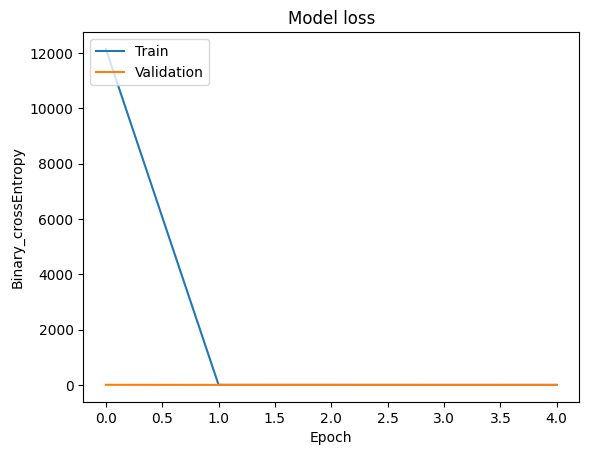

In [ ]:
#Plotting history

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Binary_crossEntropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

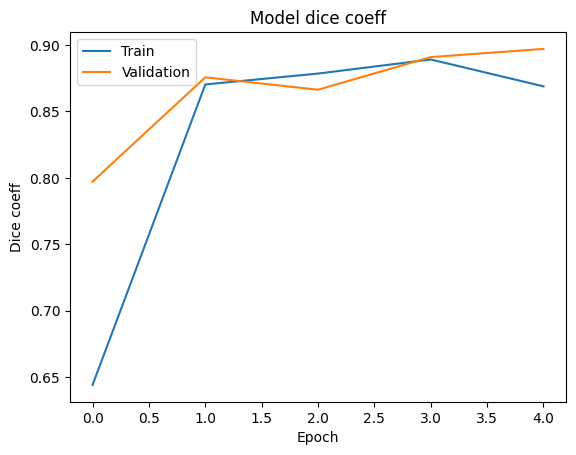

In [ ]:
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Model dice coeff')
plt.ylabel('Dice coeff')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

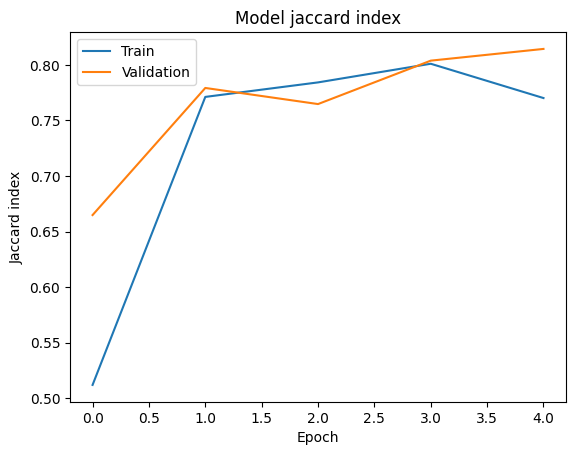

In [ ]:
plt.plot(history.history['jaccard_index'])
plt.plot(history.history['val_jaccard_index'])
plt.title('Model jaccard index')
plt.ylabel('Jaccard index')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
#Load model and test predict
#model.load_weights(r"C:\Users\User\Blood Cell Seg ipybn/cp.ckpt")

test_preds = model.predict(X_test)
print(test_preds.shape)
print(type(test_preds))

(266, 128, 128, 3)
<class 'numpy.ndarray'>


<class 'numpy.ndarray'>
(266, 128, 128, 3)
float32


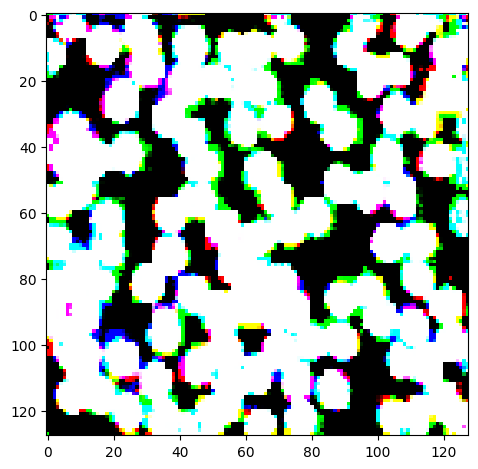

In [ ]:
print(type(test_preds))
print(test_preds.shape)
print(test_preds.dtype)
#print(test_preds[0])
imshow(test_preds[0])

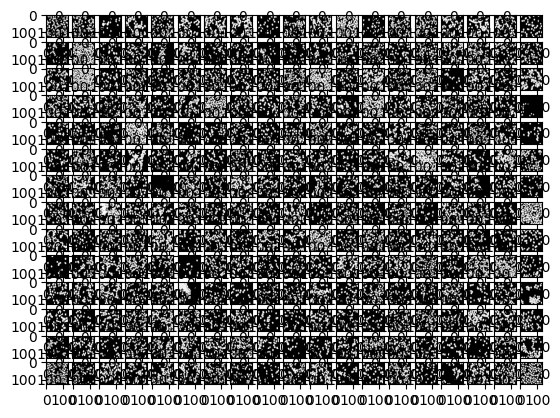

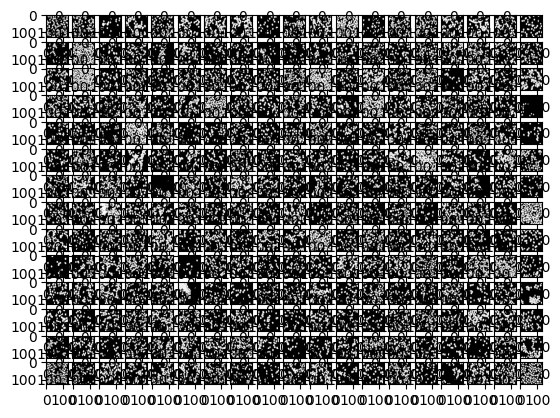

In [ ]:
from skimage.io import imshow_collection
imshow_collection(y_test)

In [ ]:
#Evaluating Individual Dice-Co efficient

In [ ]:
#Metrics for individual evaluation
def dice_coef2(a, b):

    hi = a/255
    pred = b
    hi = K.flatten(hi)
    pred = K.flatten(pred)
    upper_part = 2 * K.sum((hi * pred))
    lower_part = K.sum(hi + pred)
    dice = upper_part / lower_part
    return dice

def jaccard_index2(a, b):
    hi = a/255
    pred = b
    hi = K.flatten(hi)
    pred = K.flatten(pred)
    numerator = K.sum(hi * pred)
    denominator = K.sum((hi + pred) - (hi * pred))
    iou = numerator / denominator
    return iou

In [ ]:
import tensorflow as tf

# Assuming your dice_coef2 and jaccard_index2 functions are defined
def dice_coef2(a, b):
    a = tf.cast(a, tf.float32)
    b = tf.cast(b, tf.float32)
    intersection = tf.reduce_sum(a * b)
    return (2. * intersection) / (tf.reduce_sum(a) + tf.reduce_sum(b) + tf.keras.backend.epsilon())

def jaccard_index2(a, b):
    a = tf.cast(a, tf.float32)
    b = tf.cast(b, tf.float32)
    intersection = tf.reduce_sum(a * b)
    return intersection / (tf.reduce_sum(a) + tf.reduce_sum(b) - intersection + tf.keras.backend.epsilon())

# Average Test Dice Coefficient and Jaccard Index
avg_dice = tf.constant(0.0, dtype=tf.float32)  # Initialize as tensor
avg_jaccard = tf.constant(0.0, dtype=tf.float32)  # Initialize as tensor

# Assuming y_test and test_preds are defined as lists or tensors
for x in range(len(test_preds)):
    i = tf.cast(y_test[x], tf.float32)  # Ensure y_test is float32
    j = tf.cast(test_preds[x], tf.float32)  # Ensure test_preds is float32

    dice_value = dice_coef2(i, j)
    jaccard_value = jaccard_index2(i, j)

    # Safely accumulate the values, ensuring we handle None
    avg_dice += tf.reduce_sum(dice_value)
    avg_jaccard += tf.reduce_sum(jaccard_value)

# Calculate averages
avg_dice /= len(test_preds)
avg_jaccard /= len(test_preds)

# Using a session to evaluate the tensors
with tf.Session() as sess:
    avg_dice_value = sess.run(avg_dice)
    avg_jaccard_value = sess.run(avg_jaccard)

print('Average Test Dice Coefficient: ', avg_dice_value)
print('Average Test Jaccard Index: ', avg_jaccard_value)



Average Test Dice Coefficient:  1.867188
Average Test Jaccard Index:  42.839188


In [ ]:
history

In [ ]:
#Highest & Lowest
print('Lowest training loss: ', min(history.history['loss']))
print('Lowest validation loss: ', min(history.history['val_loss']))
print('Highest training dice coefficient: ', max(history.history['dice_coef']))
print('Highest validation dice coefficient: ', max(history.history['val_dice_coef']))
print('Highest training jaccrad index: ', max(history.history['jaccard_index']))
print('Highest validation jaccard index: ', max(history.history['val_jaccard_index']))

Lowest training loss:  1.6949120452890845
Lowest validation loss:  1.218437964671126
Highest training dice coefficient:  0.8890908
Highest validation dice coefficient:  0.8970416
Highest training jaccrad index:  0.80098933
Highest validation jaccard index:  0.8143362
